In [14]:
import kahnstatspy.GSLIB as GSLIB
import kahnstatspy.geostats as geostats
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
import matplotlib.ticker as ticker
from scipy.ndimage import rotate
from matplotlib.pyplot import cm                        # color maps
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from matplotlib.patches import Ellipse                  # plot an ellipse

In [2]:
%matplotlib inline

# Load UG90 Excel File

In [3]:
df = pd.read_csv("UG90 PROJECT.csv") #Create a data frame containing UG90 data called df

# Increasing the X and Y coordinates by 0.001
df_mod = df.copy()
df_mod['X'] = df['X'] + 0.001
df_mod['Y'] = df['Y'] + 0.001


### Load Boundary Files

In [5]:
df_lease = pd.read_excel('lease Boundary.xlsx')
df_measured = pd.read_excel('UG2 measured.xlsx')

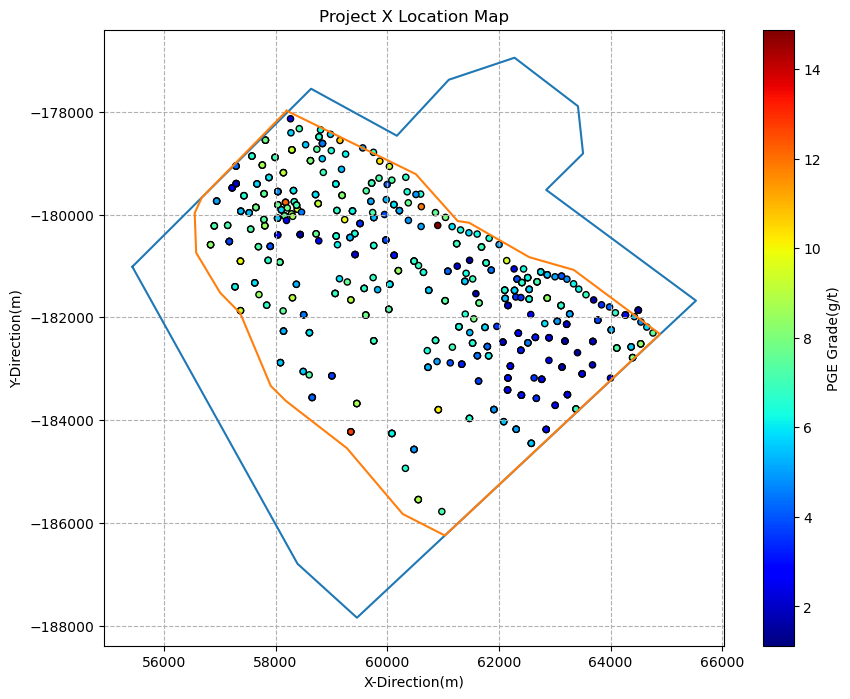

In [7]:
plt.figure(figsize=(10, 8))
plt.scatter(df_mod['X'], df_mod['Y'], c = df_mod['PGE'], s = 20, 
            edgecolors = 'black',cmap = 'jet')
cbar = plt.colorbar()
cbar.set_label("PGE Grade(g/t)", loc = 'center')
plt.title("Project X Location Map")
plt.xlabel("X-Direction(m)")
plt.ylabel("Y-Direction(m)")
plt.grid(linestyle = '--')
plt.plot(df_lease['X'],df_lease['Y'])
plt.plot(df_measured['X'],df_measured['Y'])
plt.show()

# Variogram Modelling

In [8]:
df_mod['NPGE'],tvCv,tnsCv = geostats.nscore(df_mod,'PGE')

### Variogram Parameters

In [11]:
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist=  200; lag_tol = 100; nlag = 25;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 100 ; atol = 22.5                        # no bandwidth, directional variograms
isill = 1                                                    # standardize sill
azi_mat = [0,90,45,135]

### Experimental Variograms

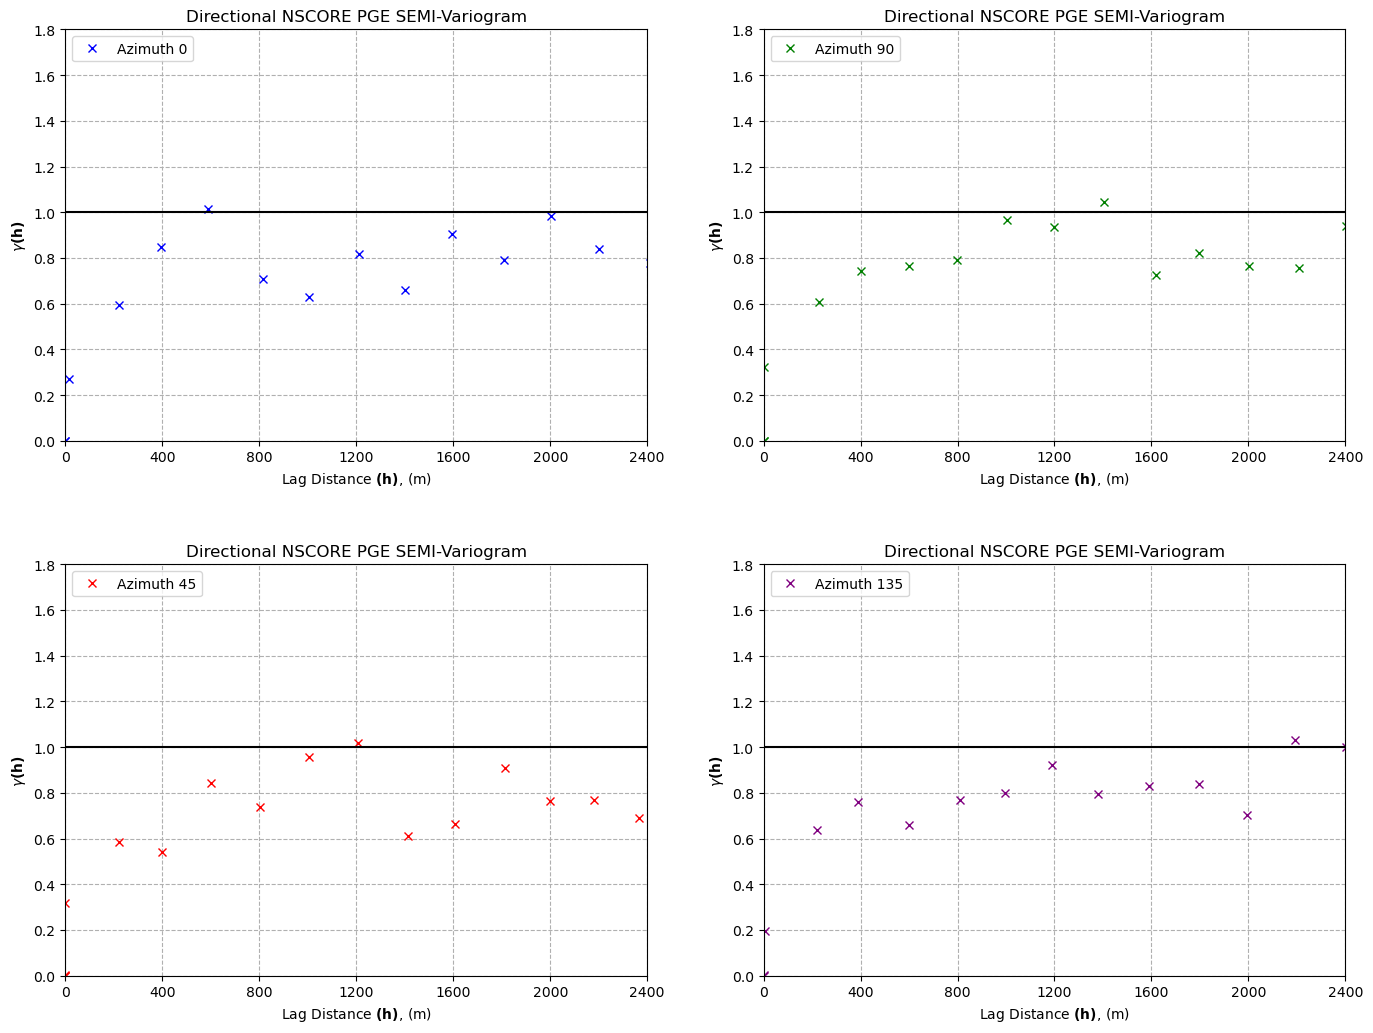

In [15]:
colors = ['blue', 'green', 'red', 'purple']

lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0, len(azi_mat)):                      
    lag[iazi, :], gamma[iazi, :], npp[iazi, :] = geostats.gamv(df_mod, "X", "Y", "NPGE", tmin, tmax, lag_dist, lag_tol, nlag, azi_mat[iazi], atol, bandh, isill)
    plt.subplot(4, 2, iazi + 1)
    plt.plot(lag[iazi, :], gamma[iazi, :], 'x', color=colors[iazi], label='Azimuth ' + str(azi_mat[iazi]))  # Use colors from the list
    plt.plot([0, 2400], [1.0, 1.0], color='black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE PGE SEMI-Variogram')
    plt.xlim([0, 2400])
    step_size = 400
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
    plt.ylim([0, 1.8])
    plt.legend(loc='upper left')
    plt.grid(True, ls = '--')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

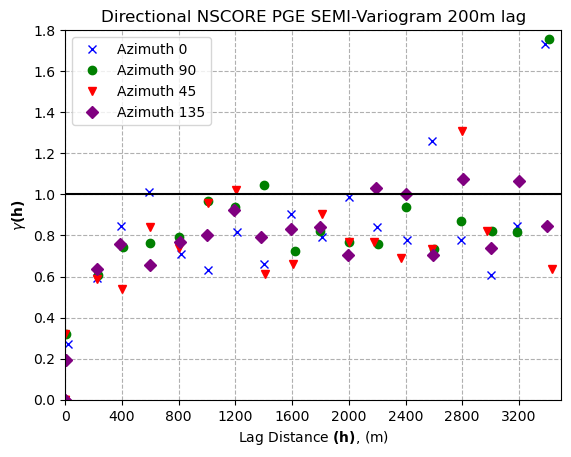

In [16]:
plt.plot(lag[0],gamma[0],'x',color = 'blue',label = 'Azimuth 0' )
plt.plot(lag[1],gamma[1],'o',color = 'green',label = 'Azimuth 90' )
plt.plot(lag[2],gamma[2],'v',color = 'red',label = 'Azimuth 45' )
plt.plot(lag[3],gamma[3],'D',color = 'purple',label = 'Azimuth 135' )
plt.plot([0,3500],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE PGE SEMI-Variogram 200m lag' )
plt.xlim([0, 3500])
step_size = 400
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True, ls = '--')

plt.show()

### Selecting preferred direction of continuity

Major direction is 135 azimuth.
Minor direction is 45 azimuth.


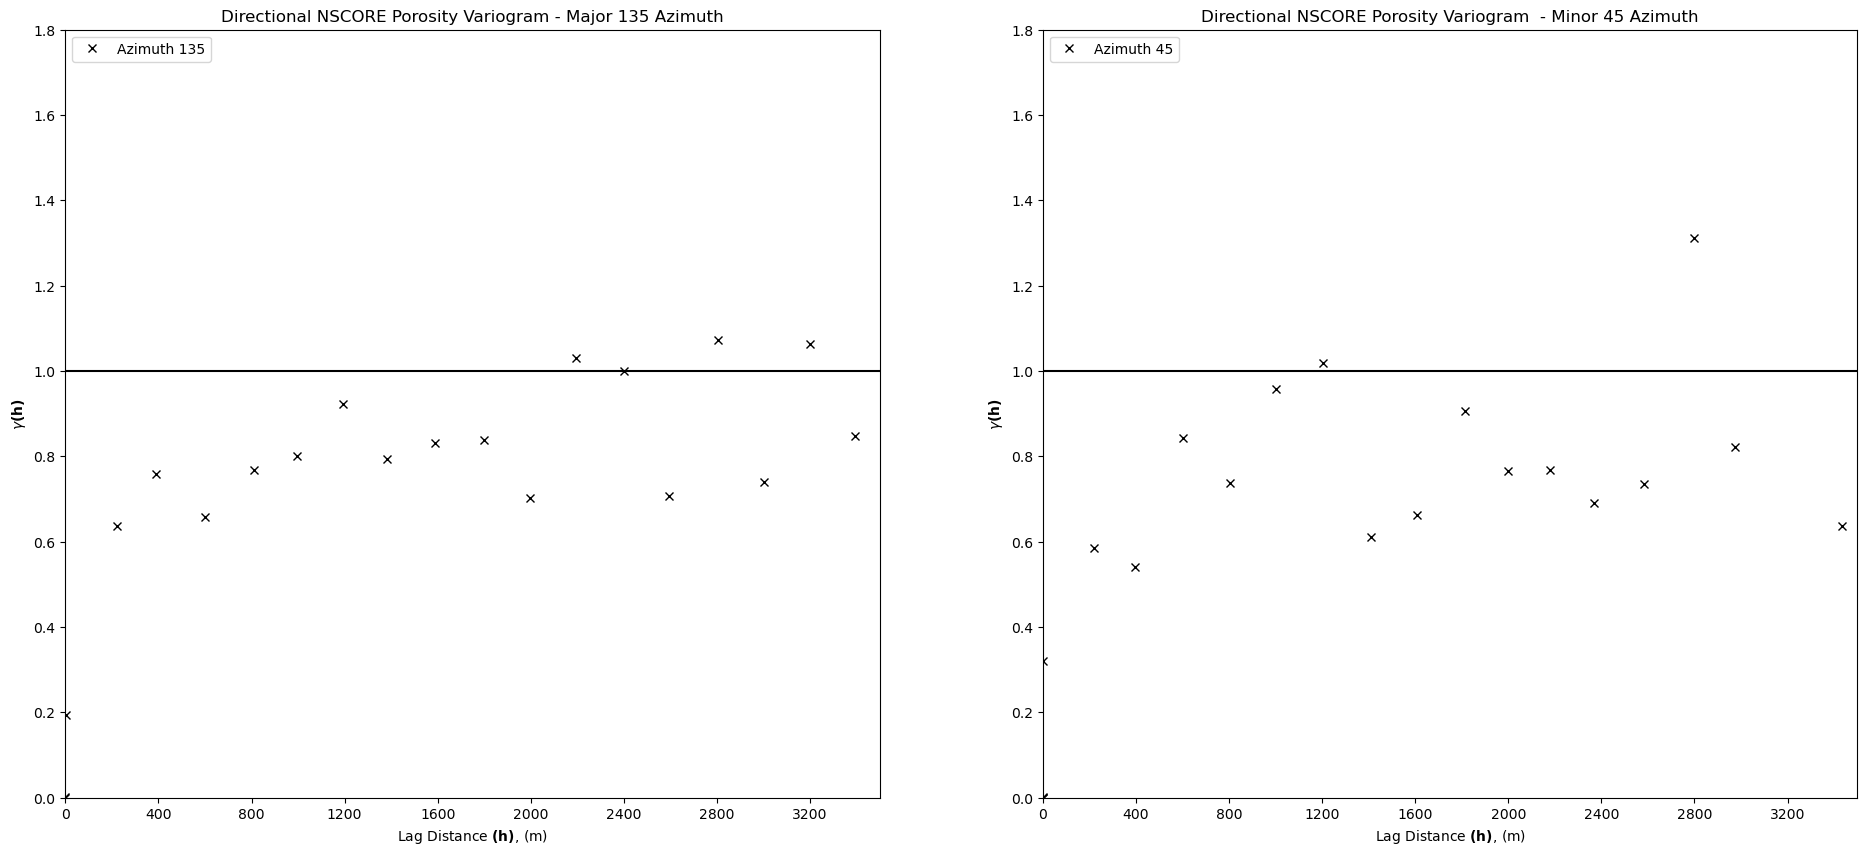

In [17]:
# Select the plot above for the major and minor
imajor = 3
iminor = 2

print('Major direction is ' + str(azi_mat[imajor]) + ' azimuth.')
print('Minor direction is ' + str(azi_mat[iminor]) + ' azimuth.')

if not abs(azi_mat[imajor] - azi_mat[iminor]) == 90.0:
    print('Major and minor directions must be orthogonal to each other.')
    sys.exit()

plt.subplot(1,2,1)
plt.plot(lag[imajor,:],gamma[imajor,:],'x',color = 'black',label = 'Azimuth ' + str(azi_mat[imajor]))
plt.plot([0,3500],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram - Major ' + str(azi_mat[imajor]) + ' Azimuth')
plt.xlim([0, 3500])
step_size = 400
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[iminor,:],gamma[iminor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iminor]))
plt.plot([0,3500],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram  - Minor ' + str(azi_mat[iminor]) + ' Azimuth')
plt.xlim([0, 3500])
step_size = 400
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
plt.ylim([0,1.8])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.8, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

# Variogram Model

In [20]:
cmap = plt.cm.plasma

# interactive calculation of the sample set (control of source parametric distribution and number of samples)
l = widgets.Text(value='                              Variogram Modeling, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
nug = widgets.FloatSlider(min = 0, max = 0.3, value = 0.0, step = 0.01, description = r'$c_{nugget}$',orientation='vertical',layout=Layout(width='80px', height='200px'))
nug.style.handle_color = 'gray'
it1 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
    description=r'$Type_1$:',disabled=False,layout=Layout(width='190px', height='30px'))
c1 = widgets.FloatSlider(min=0.0, max = 0.9, value = 0.01, description = r'$c_1$',
                         orientation='vertical',layout=Layout(width='80px', height='200px'))
c1.style.handle_color = 'blue'
hmaj1 = widgets.FloatSlider(min=0.01, max = 7000.0, value = 0.01, step = 100.0, description = r'$a_{1,maj}$',
                            orientation='vertical',layout=Layout(width='80px', height='200px'))
hmaj1.style.handle_color = 'red'
hmin1 = widgets.FloatSlider(min = 0.01, max = 7000.0, value = 0.01, step = 100.0, description = r'$a_{1,min}$',
                            orientation='vertical',layout=Layout(width='80px', height='200px'))
hmin1.style.handle_color = 'green'

it2 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
    description=r'$Type_2$:',disabled=False,layout=Layout(width='190px', height='30px'))
c2 = widgets.FloatSlider(min=0.0, max = 0.9, value = 0.0, description = r'$c_2$',orientation='vertical',
                         layout=Layout(width='80px', height='200px'))
c2.style.handle_color = 'blue'
hmaj2 = widgets.FloatSlider(min=0.01, max = 7000.0, value = 0.01, step = 100.0, description = r'$a_{2,maj}$',
                            orientation='vertical',layout=Layout(width='80px', height='200px'))
hmaj2.style.handle_color = 'red'
hmin2 = widgets.FloatSlider(min = 0.01, max = 7000.0, value = 0.01, step = 100.0, description = r'$a_{2,min}$',
                            orientation='vertical',layout=Layout(width='80px', height='200px'))
hmin2.style.handle_color = 'green'

it3 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'], value='Spherical',
                       description=r'$Type_3$:', disabled=False, layout=Layout(width='190px', height='30px'))
c3 = widgets.FloatSlider(min=0.0, max=0.9, value=0.0, description=r'$c_3$', orientation='vertical',
                         layout=Layout(width='80px', height='200px'))
c3.style.handle_color = 'blue'
hmaj3 = widgets.FloatSlider(min=0.01, max=7000.0, value=1000.0, step=100.0, description=r'$a_{3,maj}$',
                            orientation='vertical', layout=Layout(width='80px', height='200px'))
hmaj3.style.handle_color = 'red'
hmin3 = widgets.FloatSlider(min=0.01, max=7000.0, value=500.0, step=100.0, description=r'$a_{3,min}$',
                            orientation='vertical', layout=Layout(width='80px', height='200px'))
hmin3.style.handle_color = 'green'
                            
ui1 = widgets.HBox([nug,it1,c1, hmaj1, hmin1, it2, c2, hmaj2, hmin2],)                   # basic widget formatting   
ui2 = widgets.HBox([it3, c3,hmaj3,hmin3],)                   # basic widget formatting   
ui = widgets.VBox([l,ui1,ui2],)

def convert_type(it):
    if it == 'Spherical': 
        return 1
    elif it == 'Exponential':
        return 2
    else: 
        return 3

# Function to make the variogram model and plot
def f_make(nug,it1, c1, hmaj1, hmin1, it2, c2, hmaj2, hmin2, it3, c3, hmaj3, hmin3):
    text_trap = io.StringIO()
    sys.stdout = text_trap
    # Convert variogram types
    it1 = convert_type(it1)
    it2 = convert_type(it2)
    it3 = convert_type(it3)

    # Determine the number of structures
    if c3 > 0.0:
        nst = 3
    elif c2 > 0.0:
        nst = 2
    else:
        nst = 1
    
    vario = GSLIB.make_variogram3(nug,nst,it1,c1,azi_mat[imajor],hmaj1,hmin1,it2,c2,azi_mat[imajor],hmaj2,hmin2, it3, c3, azi_mat[imajor], hmaj3, hmin3) # make model object
    nlag = 1000; xlag = 10;                                     
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel3(nlag,xlag,azi_mat[imajor],vario)   # project the model in the major azimuth                                                  # project the model in the 135 azimuth
    index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel3(nlag,xlag,azi_mat[iminor],vario) # project the model in the minor azimuth
    
    plt.subplot(2,2,1)
    plt.plot(lag[imajor,:],gamma[imajor,:],'x',color = 'red',label = 'Azimuth ' +str(azi_mat[3]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'red')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Major Directional NSCORE PGE Variogram - Major ' + str(azi_mat[imajor]) + 'Azimuth')
    plt.xlim([0, 2000])
    step_size = 400
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
    plt.ylim([0,1.8])
    plt.grid(ls = '--')
    plt.legend(loc='upper left')
    
    plt.subplot(2,2,2)
    plt.plot(lag[iminor,:],gamma[iminor,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[2]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.plot(h_min,gam_min,color = 'blue')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Minor Directional NSCORE PGE Variogram - Minor ' + str(azi_mat[iminor]) + 'Azimuth')
    plt.xlim([0, 2000])
    step_size = 400
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
    plt.ylim([0,1.8])
    plt.grid(ls = '--')
    plt.legend(loc='upper left')
    
    plt.subplot(2,2,3)
    plt.plot([0,4000],[1.0,1.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'red',label = 'Azimuth ' + str(azi_mat[imajor]))    
    plt.plot(h_min,gam_min,color = 'blue',label = 'Azimuth ' + str(azi_mat[iminor]))
    deltas = [22.5, 45, 67.5]; 
    ndelta = len(deltas); hd = np.zeros(ndelta); gamd = np.zeros(ndelta);
    color=iter(cm.plasma(np.linspace(0,1,ndelta)))
    for delta in deltas:
        index,hd,gamd,cov,ro = geostats.vmodel(nlag,xlag,azi_mat[imajor]+delta,vario);
        c=next(color)
        plt.plot(hd,gamd,color = c,label = 'Azimuth ' + str(azi_mat[imajor]+delta))
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Interpolated Azimuth NSCORE PGE Variogram Models')
    plt.xlim([0, 4000])
    step_size = 400
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step_size))
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    
    
  #  plt.subplot(2,2,4)
   # GSLIB.locmap_st(df_mod,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

    #plt.scatter(x1,y1,color = 'blue', edgecolors = 'black', s = sk_weights[0,0]*1000)
    #plt.scatter(x2,y2,color = 'red', edgecolors = 'black', s = sk_weights[0,1]*1000)
    #plt.scatter(x3,y3,color = 'green', edgecolors = 'black', s = sk_weights[0,2]*1000)
    #scatter = plt.scatter(500,500,color = 'gray', edgecolors = 'black', s = (1-sk_std)*1000)
    #ax = plt.gca()
    #plt.xlabel('X(m)'); plt.ylabel('Y(m)')
    #plt.title('Data and Variogram Ranges for Each Structure')
    #plt.xlim([0,5000])
    #plt.ylim([0,5000])

    #ellipse1 = Ellipse((5000, 5000),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi_mat[imajor],facecolor='orange',alpha = 0.3,edgecolor='black',label='Structure 1')
    #ellipse2 = Ellipse((5000, 5000),width=hmin2*2.0,height=hmaj2*2.0,angle = 360-azi_mat[imajor],facecolor='red',alpha = 0.3,edgecolor='black',label='Structure 2')
    #ax = plt.gca()
    #ax.add_patch(ellipse1); ax.add_patch(ellipse2)
    #plt.legend()
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.3, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make,{'nug':nug,'it1': it1, 'c1': c1, 'hmaj1': hmaj1, 'hmin1': hmin1,'it2': it2, 'c2': c2, 'hmaj2': hmaj2, 'hmin2': hmin2,'it3': it3, 'c3': c3, 'hmaj3': hmaj3, 'hmin3': hmin3})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

In [21]:
display(ui, interactive_plot)     

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 3 Axes>', 'i…